### Imports

In [12]:
import numpy as np
import pandas as pd
import string
from gensim.models import KeyedVectors
import spacy
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import compress_fasttext

### Load Datasets

In [13]:
df_train = pd.read_csv('Sentiment-Analysis/train_data.csv', delimiter=',')[: 80]
df_train = df_train[df_train['label'] != 1]
df_train['label'] = np.where(df_train['label'] == 2, 1, 0)
df_train

,text,label
0,almost got in a giant car accident on the 101,0
1,like something wholly original,1
2,b.s. one another,0
3,"Happy Star Wars Day, may the 4th be with you ...",1
4,few new converts,0
...,...,...
75,I had high hopes when sitting down to watch Th...,0
76,"complex , unpredictable character",1
77,ominous mood and tension,0
78,exquisitely,1


In [3]:
df_val = pd.read_csv('Sentiment-Analysis/val_data.csv', delimiter=',')[: 20]
df_val = df_val[df_val['label'] != 1]
df_val['label'] = np.where(df_val['label'] == 2, 1, 0)
df_val

,text,label
0,WOOOOOOOOOO are you coming to Nottingham at...,1
1,"and thanks, , fr. yr congratulatory gweetin`",1
2,wonderous accomplishment,1
3,the pungent bite of its title,0
4,sketchy characters and immature provocations,0
5,knows how to inflate the mundane into the scar...,1
6,the action as gripping,1
7,would make it a great piece to watch with kids...,1
8,riveting performances,1
9,has a rather unique approach to documentary,1


In [4]:
df_test = pd.read_csv('Sentiment-Analysis/test_data.csv', delimiter=',')[: 10]
df_test = df_test[df_test['label'] != 1]
df_test['label'] = np.where(df_test['label'] == 2, 1, 0)
df_test

,text,label
0,find a spark of its own,1
1,oh come on .,0
2,winningly,1
3,an old-fashioned but emotionally stirring adve...,1
4,"salt and vinegar, cheese and onion make your ...",0
5,wickedly funny and just plain wicked,1
6,bad ideas and awkwardness,0
7,what distinguishes time of favor from countles...,1
8,"the proficient , dull sorvino has no light tou...",0
9,trying to finish moving stuff for tonight don`...,0


### Labels

In [5]:
Y_train = list(df_train['label'])
Y_val = list(df_val['label'])
Y_test = list(df_test['label'])
# positive, negative
print(Y_train.count(0), Y_train.count(1))
print(Y_val.count(0), Y_val.count(1))
print(Y_test.count(0), Y_test.count(1))

31 41
4 16
5 5


### Embedding Matrix

In [6]:
# embeddings = KeyedVectors.load_word2vec_format("models/GoogleNewsvectorsnegative300.bin", binary=True, limit=100000)
embeddings = compress_fasttext.models.CompressedFastTextKeyedVectors.load("models/cc.en.300.compressed.bin")

In [7]:
vocab = {'<UNK>': 0, '<PAD>': 1}

for i, w in enumerate(embeddings.index_to_key):
    vocab[w] = i + 2

emb = np.zeros((len(vocab), 300))
for w, i in vocab.items():
    emb[i] = embeddings[w]
emb = torch.tensor(emb, dtype=torch.float32)
print(emb.shape)

torch.Size([20002, 300])


In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, nlp, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        self.nlp = nlp

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        txt = self.texts[idx].lower().strip(string.punctuation).strip()
        tokens = [token.text for token in self.nlp(txt) if
                  not token.is_stop and not token.is_punct and not token.is_space and not token.like_num]
        indices = [self.vocab.get(token) if self.vocab.get(token) is not None else self.vocab.get('<UNK>')for token in tokens]
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(self.labels[idx], dtype=torch.long)


nlp = spacy.load('en_core_web_sm')

train_dataset = SentimentDataset(texts=list(df_train['text']), labels=list(df_train['label']), nlp=nlp, vocab=vocab,
                                 max_len=30)
train_loader = DataLoader(train_dataset, batch_size=8)

val_dataset = SentimentDataset(texts=list(df_val['text']), labels=list(df_val['label']), nlp=nlp, vocab=vocab,
                               max_len=30)
val_loader = DataLoader(val_dataset, batch_size=8)

test_dataset = SentimentDataset(texts=list(df_test['text']), labels=list(df_test['label']), nlp=nlp, vocab=vocab,
                                max_len=30)
test_loader = DataLoader(test_dataset, batch_size=8)

### Feed-Forward Network

In [9]:
class FFN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, emb_matrix):
        super(FFN, self).__init__()
        self.embedding = nn.Embedding(in_feats, emb_matrix.shape[1])
        self.embedding.weight = nn.Parameter(emb_matrix, requires_grad=True)
        self.lin1 = nn.Linear(emb_matrix.shape[1], hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size, out_feats)

    def forward(self, X):
        e = self.embedding(X)
        e = e.mean(dim=1)

        input = self.lin1(e)
        hidden = self.relu(input)
        out = self.lin2(hidden)

        return out


### Trainer

In [11]:
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return precision, recall, f1


device = 'cuda' if torch.cuda.is_available() else 'cpu'

### hyperparameters
in_feats = len(vocab)
hidden_size = in_feats * 8
out_classes = 1
epochs = 50
early_stopping = 50
lr = 1e-5
model_name = 'best-model'

### neural net
ffn = FFN(in_feats=in_feats, hidden_size=hidden_size, out_feats=out_classes, emb_matrix=emb).to(device)

### optimizer - AdamW = architectural variant of Gradient Descent
opt = torch.optim.AdamW(ffn.parameters(), lr=lr)

### loss function
### 1. Binary Classification - BCELoss(), BCEWithLogitsLoss, target float
### difference - needs sigmoid/internal sigmoid

### 2. Multi Class Classification - NLLLoss(), CrossEntropyLoss(), target long
### difference - needs softmax/internal softmax 


loss_fn = torch.nn.BCEWithLogitsLoss()

best_f1, best_model_dict, bestloss = 0.0, None, 0.0
tolerance = early_stopping

for epoch in tqdm(range(epochs), desc='Training Started'):
    epoch_loss = []
    for examples, y in train_loader:
        # BCE
        y = y.float().unsqueeze(1).to(device)
        opt.zero_grad()

        y_hat = ffn(examples.to(device))
        loss = loss_fn(y_hat, y)

        epoch_loss.append(loss.item())
        loss.backward()

        opt.step()

    ### evaluation every epoch 
    ### on dev set
    y_true, y_pred = [], []
    for examples, y in val_loader:
        y_hat = ffn(examples.to(device))
        y_true.extend([_.item() for _ in y])
        y_pred.extend([1 if _.item() >= .5 else 0 for _ in torch.sigmoid(y_hat).squeeze(1)])

    p, r, f1 = compute_metrics(y_true, y_pred)

    if best_f1 < f1:
        best_f1 = f1
        best_model_dict = deepcopy(ffn.state_dict())
        tolerance = early_stopping
        bestloss = sum(epoch_loss) / len(epoch_loss)
    else:
        tolerance -= 1
        if tolerance == 0:
            print(f'no improvement for {early_stopping} epochs')
            break

    print(f'epoch: {epoch + 1} '
          f'loss: {sum(epoch_loss) / len(epoch_loss)}\n'
          f'metrics: {p, r, f1}')



Training Started:   0%|          | 0/50 [00:00<?, ?it/s]D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:   2%|▏         | 1/50 [00:06<05:14,  6.43s/it]

epoch: 1 loss: 0.6943868266211616
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:   4%|▍         | 2/50 [00:10<04:06,  5.14s/it]

epoch: 2 loss: 0.6885367300775316
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:   6%|▌         | 3/50 [00:14<03:37,  4.62s/it]

epoch: 3 loss: 0.6851463715235392
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:   8%|▊         | 4/50 [00:18<03:23,  4.41s/it]

epoch: 4 loss: 0.6830445925394694
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  10%|█         | 5/50 [00:22<03:12,  4.28s/it]

epoch: 5 loss: 0.6816686789194742
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  12%|█▏        | 6/50 [00:26<03:05,  4.21s/it]

epoch: 6 loss: 0.6806486050287882
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  14%|█▍        | 7/50 [00:31<02:59,  4.18s/it]

epoch: 7 loss: 0.6797770195537143
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  16%|█▌        | 8/50 [00:35<02:58,  4.26s/it]

epoch: 8 loss: 0.6789537800682915
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  18%|█▊        | 9/50 [00:39<02:57,  4.34s/it]

epoch: 9 loss: 0.6781367328431871
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  20%|██        | 10/50 [00:44<02:50,  4.27s/it]

epoch: 10 loss: 0.6773107184304131
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  22%|██▏       | 11/50 [00:48<02:45,  4.24s/it]

epoch: 11 loss: 0.6764714121818542
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  24%|██▍       | 12/50 [00:52<02:41,  4.25s/it]

epoch: 12 loss: 0.6756178339322408
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  26%|██▌       | 13/50 [00:56<02:35,  4.22s/it]

epoch: 13 loss: 0.6747499704360962
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  28%|██▊       | 14/50 [01:00<02:31,  4.20s/it]

epoch: 14 loss: 0.673867854807112
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  30%|███       | 15/50 [01:05<02:28,  4.25s/it]

epoch: 15 loss: 0.6729711360401578
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  32%|███▏      | 16/50 [01:09<02:23,  4.21s/it]

epoch: 16 loss: 0.6720594763755798
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  34%|███▍      | 17/50 [01:13<02:18,  4.20s/it]

epoch: 17 loss: 0.6711324916945564
metrics: (0.4, 0.5, 0.4444444444444444)


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Started:  36%|███▌      | 18/50 [01:17<02:18,  4.32s/it]


epoch: 18 loss: 0.6701894137594435
metrics: (0.4, 0.5, 0.4444444444444444)


KeyboardInterrupt: 

### Save

In [71]:
torch.save({'state_dict': best_model_dict, 'embeddings': deepcopy(emb), 'epochs': epochs,
            'early_stopping': early_stopping, 'loss': bestloss,
            'loss_fn': loss_fn.__class__.__name__,
            'optimizer': opt.__class__.__name__,
            'in_feats': in_feats, 'hidden_size': hidden_size, 'out_feats': out_classes, 'lr': lr,
            'test_loader': deepcopy(test_loader)},
           f'models/{model_name}.pt')

### Evaluate

In [73]:
model_saved = torch.load('models/best-model-bin.pt', weights_only=False, map_location=device)

ffn.load_state_dict(model_saved['state_dict'])

with torch.no_grad():
    y_true, y_pred = [], []
    for examples_test, y_test in test_loader:
        y_hat = ffn.forward(examples_test.to(device))
        y_true.extend([_.item() for _ in y_test])
        y_pred.extend([1 if _.item() >= .5 else 0 for _ in torch.sigmoid(y_hat).squeeze(1)])

compute_metrics(y_true, y_pred)

(0.8149681803783799, 0.7780251846655177, 0.7821005060884619)

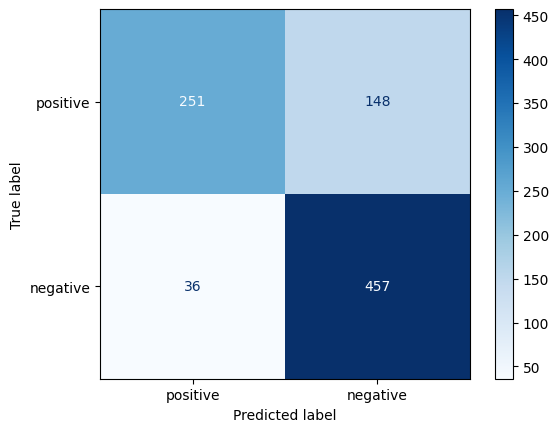

In [75]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['positive', 'negative']).plot(
    cmap=plt.cm.Blues)
plt.show()